Mito_Energy significant (p<0.05): ['OXPHOS', 'Complex_I_V', 'Complex_IV']
MetabolicShift significant (p<0.05): ['Metabolism', 'Fatty_Acid_Synthesis', 'Fatty_Acid_Oxidation', 'Pentose_Phosphate_Cycle', 'Nucleotide_Synthesis', 'Folate_Single_Carbon', 'Antioxidant_Defenses']
Immune_stress_response significant (p<0.05): ['Canonical', 'Inflammation', 'Cytokines', 'Interleukins', 'mtDNA_Activated', 'Inhibited_Senescence', 'Necroptosis', 'Apoptosis', 'Extracellular_Matrix']


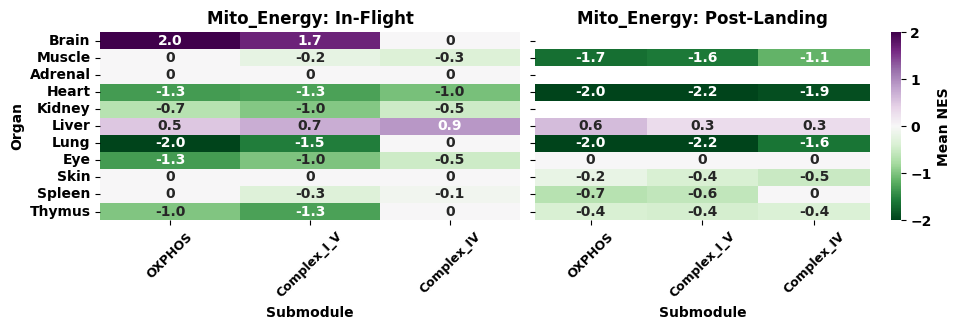

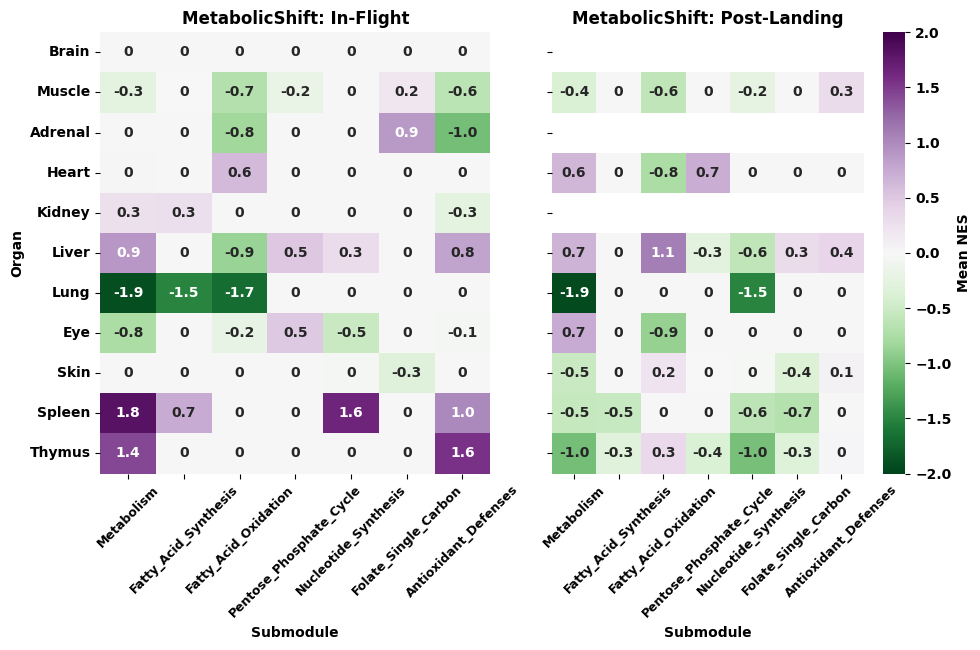

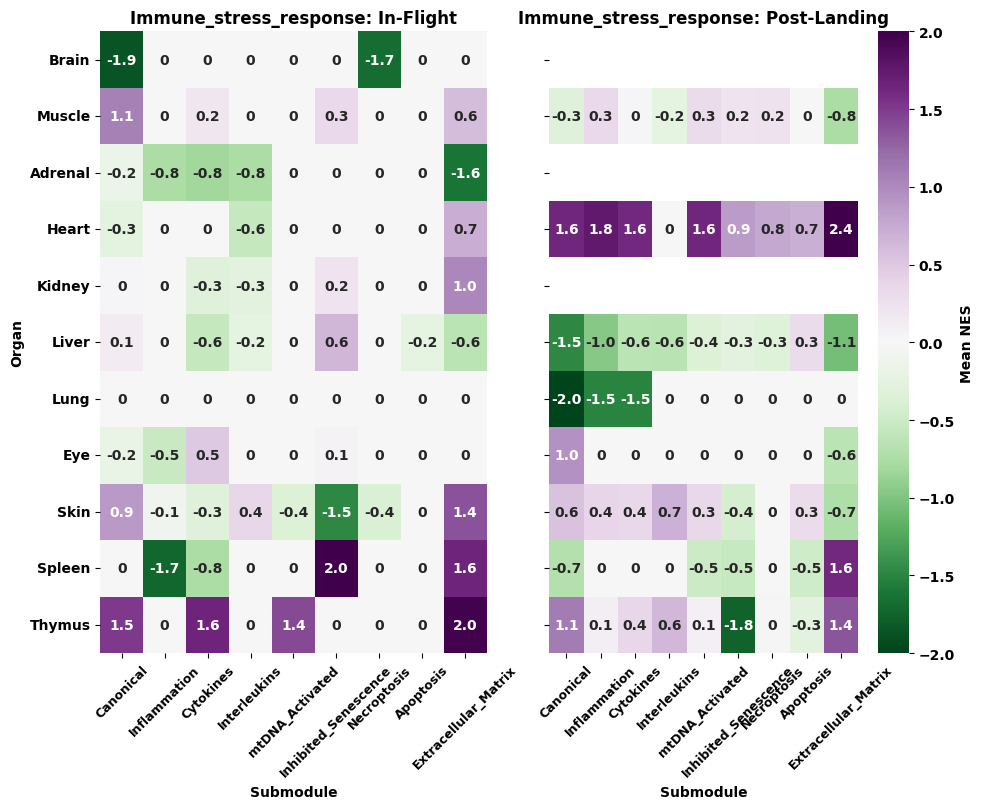

In [7]:
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the data
df = pd.read_excel('All_strain.xlsx')

# Define the three pathway groups by column index
group1_cols = df.columns[9:21]    # Mitochondria complexes & proteins
group2_cols = df.columns[22:38]   # Metabolic shift markers
group3_cols = df.columns[38:]     # Immune & stress response markers

# Compute per-sample NES averages
df['Mito_Energy'] = df[group1_cols].mean(axis=1)
df['MetabolicShift'] = df[group2_cols].mean(axis=1)
df['Immune_stress_response'] = df[group3_cols].mean(axis=1)

# Calculate Overall_NES
df['Overall_NES'] = df[['Mito_Energy', 'MetabolicShift', 'Immune_stress_response']].mean(axis=1)

# Prepare “status” column
df['Status'] = np.where(df.Return_Days==0, 'In-Flight', 'Post-Landing')

# Common color map
status_order = ['In-Flight','Post-Landing']

# Prepare a small DataFrame
rd = df[df.Status.isin(['In-Flight','Post-Landing'])][['Overall_NES','Status']]

# Create RadiosensitivityGroup
def map_rad(x):
    if x in [5, 4]:
        return 'Low'
    if x == 3:
        return 'Mid'
    if x in [2, 1]:
        return 'High'
    return 'Unknown'
df['RadiosensitivityGroup'] = df['Radio_Sensitivity'].apply(map_rad)

# Define the sets of columns for each pathway group
sets = {
    'Mito_Energy': df.columns[9:21],  # Mitochondria complexes & proteins
    'MetabolicShift': df.columns[22:38],   # Metabolic shift markers
    'Immune_stress_response': df.columns[38:]     # Immune & stress response markers
}

# ── 1) Filter submodules by t-test (In-Flight vs Post-Landing) ───────────────
sig_subs = {}
for name, cols in sets.items():
    sig_subs[name] = []
    for col in cols:
        # Convert column to numeric, coercing errors to NaN
        numeric_col = pd.to_numeric(df[col], errors='coerce')
        a = numeric_col[df.Status=='In-Flight'].dropna()
        b = numeric_col[df.Status=='Post-Landing'].dropna()
        if len(a)>2 and len(b)>2:
            t, p = ttest_ind(a, b, equal_var=False)
            if p < 0.05:
                sig_subs[name].append(col)

# Print what came out significant
for name, subs in sig_subs.items():
    print(f"{name} significant (p<0.05):", subs)


# ── 2) Heatmaps of just the significant submodules ────────────────────────────
low_orgs  = sorted(df[df.RadiosensitivityGroup=='Low']['Organ'].unique())
mid_orgs  = sorted(df[df.RadiosensitivityGroup=='Mid']['Organ'].unique())
high_orgs = sorted(df[df.RadiosensitivityGroup=='High']['Organ'].unique())

# 2) Desired bottom-to-top order is: High, Mid, Low
organs = low_orgs + mid_orgs + high_orgs

vmin, vmax = -2, 2
cmap='PRGn_r'

for name, subs in sig_subs.items():
    if not subs:
        continue
    fig, axes = plt.subplots(1, 2, figsize=(10, len(subs)*0.8+1), sharey=True)
    for ax, status in zip(axes, ['In-Flight','Post-Landing']):
        sub = df[df.Status==status]
        heat = (sub.groupby('Organ')[subs]
                   .mean()
                   .reindex(index=organs, columns=subs))
        # Round to one decimal and keep plain zeros:
        heat_rounded = heat.round(1)
        annot = heat_rounded.astype(str).mask(heat_rounded == 0, '0')
        sns.heatmap(
            heat, ax=ax, annot=annot, fmt="",
            cmap=cmap, center=0, vmin=vmin, vmax=vmax,
            cbar=(status=='Post-Landing'),
            cbar_kws={'label':'Mean NES'}
        )
        ax.set_title(f"{name}: {status}", fontsize=12)
        out_fname = f"{name.replace(' ', '_')}_IFvsPF.svg"
        ax.set_xlabel('Submodule')
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        if ax is axes[0]:
            ax.set_ylabel('Organ')
        else:
            ax.set_ylabel('')

    # fig.suptitle(f"Significant {name} Submodules by Status", y=1.02, fontsize=14)
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"
    plt.tight_layout()
    plt.savefig(out_fname,format='svg', dpi=600, transparent=False)
    plt.show()
    plt.close(fig)